In [1]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from notebooks.pcm.utils import ZScalesExtractor

In [4]:
mic = pd.read_csv("data/raw/MIC_pIC50_values.csv")

In [5]:
seq = pd.read_csv("data/raw/peptide_target_seq.csv")

In [6]:
seq = seq.merge(mic, on='Sequence')

In [7]:
zscale = ZScalesExtractor("data/raw/z_scales_5.csv")

In [8]:
zscales_features = zscale.transform(seq)

In [9]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
seq.shape

(50, 7)

In [12]:
def optimise_rf_cv(X, y, n_comp):
    # Define PLS object
    rf = RandomForestRegressor(n_estimators=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(rf, X, y, cv=50)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    mape = mean_absolute_percentage_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, mape, rpd)

In [13]:
r2s = []
mses = []
mapes = []
rpds = []
xticks = [100, 200, 250, 300, 500, 1000, 1500]#zscales_features.shape[1]-1)
for n_comp in xticks:
    y_cv, r2, mse, mape, rpd = optimise_rf_cv(zscales_features, seq['pIC50'], n_comp)
    r2s.append(r2)
    mses.append(mse)
    mapes.append(mape)
    rpds.append(rpd)

In [14]:
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

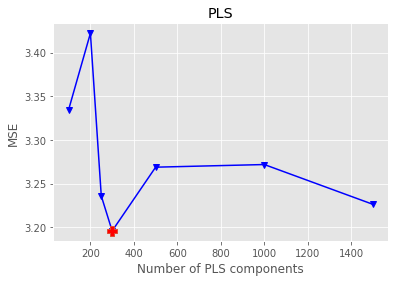

In [15]:
plot_metrics(mses, 'MSE', 'min')

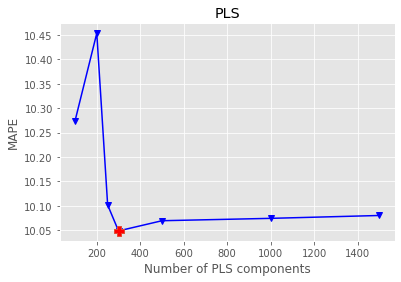

In [16]:
plot_metrics(mapes, 'MAPE', 'min')

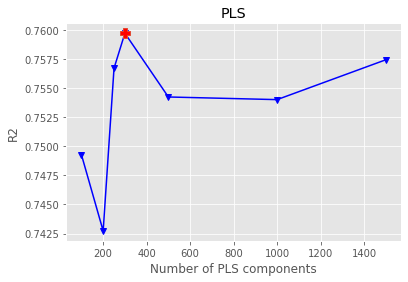

In [17]:
plot_metrics(r2s, 'R2', 'max')

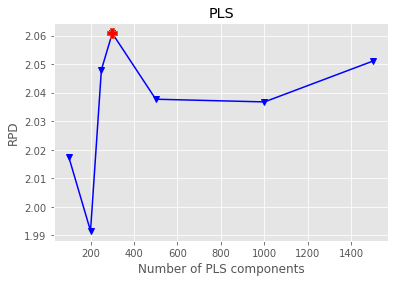

In [18]:
plot_metrics(rpds, 'RPD', 'max')

In [19]:
pd.DataFrame(list(zip(mses, mapes, r2s, rpds)), columns=['MSE', 'MAPE', 'R2', 'RPD'])

,MSE,MAPE,R2,RPD
0,3.334827,10.273973,0.749286,2.017426
1,3.422124,10.453345,0.742723,1.991528
2,3.235952,10.101681,0.756719,2.048016
3,3.195902,10.048552,0.759730,2.060808
4,3.268844,10.069425,0.754247,2.037685
5,3.271870,10.074287,0.754019,2.036743
6,3.226277,10.080163,0.757447,2.051084


In [21]:
y_pred_mic = np.exp(-y_cv)/1e-6

In [22]:
mean_absolute_percentage_error(seq['pIC50'], y_pred_mic)

369.8017378805339